In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# keras
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2  import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Directories of image data
BASE_IMAGE_DIRECTORY = r"C:\Users\linke\Documents\Datasets\flowers"
TRAIN_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "train")
VAL_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "val")
TEST_IMAGE_DIRECTORY = os.path.join(BASE_IMAGE_DIRECTORY, "test")

Using TensorFlow backend.


# Analyse Dataset

In [2]:
classes = os.listdir(TRAIN_IMAGE_DIRECTORY) # dir is your directory path
number_classes = len(classes)
print ("Amount of classes: ", number_classes)
print("class names", classes)

Amount of classes:  5
class names ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
# function for plotting amount of images in a folder
def plot_data(path):
    classes_images = []
    dict_classes_images = {}
    for class_name in classes:
        path_class = os.path.join(path, class_name)
        classes_images.append(len(os.listdir(path_class)))
    dict_classes_images["classes"] = classes
    dict_classes_images["amount"] = classes_images
    sns.barplot(y="amount", x="classes",data=dict_classes_images)
    plt.show()

TRAIN DATA


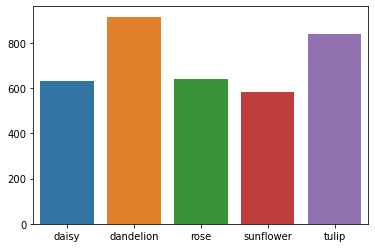

VAL DATA


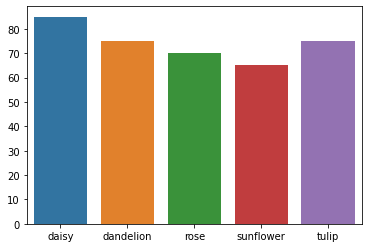

TESET DATA


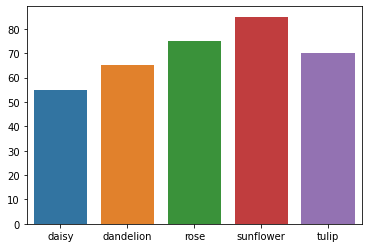

In [4]:
print("TRAIN DATA")
plot_data(TRAIN_IMAGE_DIRECTORY)
print("VAL DATA")
plot_data(VAL_IMAGE_DIRECTORY)
print("TESET DATA")
plot_data(TEST_IMAGE_DIRECTORY)

In [5]:
flower_dir = os.path.join(TRAIN_IMAGE_DIRECTORY,classes[0])
image_filename = os.listdir(flower_dir)[0]
image_dir = os.path.join(flower_dir,image_filename)


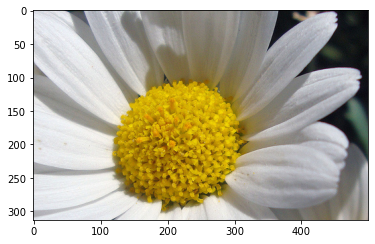

In [6]:
test_image = cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

# Loading the model

In [7]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
MODEL = MobileNetV2(include_top=False, weights='imagenet',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3), pooling="avg") 
MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = MODEL(inputs)
dense1 = keras.layers.Dense(1024, activation='relu')(x)
dense2 = keras.layers.Dense(512, activation='relu')(dense1)
outputs = keras.layers.Dense(len(classes),activation='softmax')(dense2)

FINAL_MODEL = keras.Model(inputs, outputs)
FINAL_MODEL.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 4,097,093
Trainable params: 4,062,981
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
FINAL_MODEL.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              metrics= ["acc", "Precision", "Recall"])

# Data Augmentation

In [10]:
BATCH_SIZE = 32

In [11]:
# define data augmentations
train_datagenerator = ImageDataGenerator(
        rotation_range=10, # rotation
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.8,1.2],
        fill_mode="nearest",
        preprocessing_function=preprocess_input) 
# Note that the validation data should not be augmented!
val_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

# TEST DATA GENERATOR
test_datagenerator = ImageDataGenerator(preprocessing_function=preprocess_input)

Found 3603 images belonging to 5 classes.
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


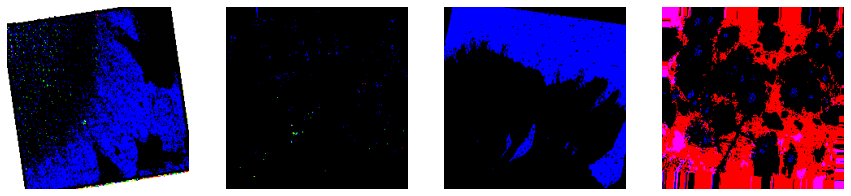

In [12]:
# augment data

train_generator = train_datagenerator.flow_from_directory(
                  directory=TRAIN_IMAGE_DIRECTORY,
                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=1, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=2020 # to make the result reproducible
                  )

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)
  print(image.shape)

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

In [13]:
# increase batch size 
train_generator = train_datagenerator.flow_from_directory(
                  directory=TRAIN_IMAGE_DIRECTORY,
                  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), # resize to this size
                  color_mode="rgb", # for coloured images
                  batch_size=BATCH_SIZE, # number of images to extract from folder for every batch
                  class_mode="categorical", # classes to predict
                  seed=2020 # to make the result reproducible
                  )

val_generator = val_datagenerator.flow_from_directory(
    VAL_IMAGE_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode="rgb", # for coloured images
    batch_size=BATCH_SIZE, # number of images to extract from folder for every batch
    class_mode="categorical", # classes to predict
    seed=2020) # to make the result reproducible) # set as validation data

#Test data generator for USING the Test Data set during training


test_generator = test_datagenerator.flow_from_directory(
    TEST_IMAGE_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode="rgb", # for coloured images
    batch_size=1, # number of images to extract from folder for every batch
    class_mode="categorical", # classes to predict
    seed=2020) # to make the result reproducible) # set as validation data

Found 3603 images belonging to 5 classes.
Found 370 images belonging to 5 classes.
Found 350 images belonging to 5 classes.


In [14]:
history = FINAL_MODEL.fit(
    train_generator,
    steps_per_epoch = np.floor(train_generator.samples  // BATCH_SIZE),#-> in this way, each training sample is augmented one time in each epoch
    validation_data = val_generator, 
    validation_steps = np.floor(val_generator.samples  // BATCH_SIZE),
    epochs = 10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 112.0 steps, validate for 11.0 steps
Epoch 1/10
112/112 [==============================] - 48s 430ms/step - loss: 1.2796 - acc: 0.5410 - Precision: 0.9449 - Recall: 0.1056 - val_loss: 0.9711 - val_acc: 0.6733 - val_Precision: 0.9123 - val_Recall: 0.2955
Epoch 2/10
112/112 [==============================] - 41s 370ms/step - loss: 0.7094 - acc: 0.8029 - Precision: 0.9430 - Recall: 0.5606 - val_loss: 0.5643 - val_acc: 0.8125 - val_Precision: 0.8921 - val_Recall: 0.7045
Epoch 3/10
112/112 [==============================] - 42s 374ms/step - loss: 0.4719 - acc: 0.8533 - Precision: 0.9281 - Recall: 0.7595 - val_loss: 0.4128 - val_acc: 0.8580 - val_Precision: 0.9038 - val_Recall: 0.8011
Epoch 4/10
112/112 [==============================] - 42s 375ms/step - loss: 0.3714 - acc: 0.8815 - Precision: 0.9296 - Recall: 0.8250 - val_loss: 0.3137 - val_acc: 0.8864 - val_Precision: 0.9264 - val_Recall: 0.8580
Epoch 5/10
112/112 [===============

In [15]:
FINAL_MODEL.save("flower_predictor.h5")

# Plot Accuracy

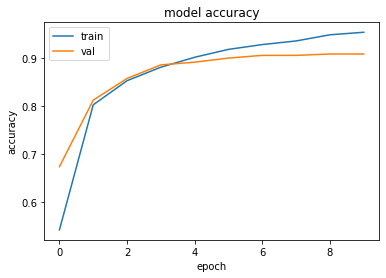

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

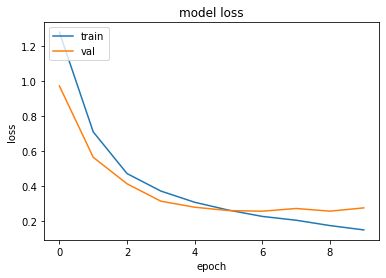

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Validation on test data

In [20]:
test_score = FINAL_MODEL.evaluate_generator(test_generator)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

  ...
    to  
  ['...']
VAL SCORE
[INFO] accuracy: 89.71%
[INFO] Loss:  0.3090494551666981


In [21]:
# model is overfitting